In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()
%output size=150
pi_ticks = [(-np.pi, r'$-\pi$'), (0, '0'), (np.pi, r'$\pi$')]

def qhe_hall_bar(L=50, W=10, w_lead=10, w_vert_lead=None):
    """Create a hall bar system. 

    Square lattice, one orbital per site.
    Returns finalized kwant system.

    Arguments required in onsite/hoppings: 
        t, mu, mu_lead
    """

    L = 2 * (L // 2)
    W = 2 * (W // 2)
    w_lead = 2 * (w_lead // 2)
    if w_vert_lead is None:
        w_vert_lead = w_lead
    else:
        w_vert_lead = 2 * (w_vert_lead // 2)

    # bar shape
    def bar(pos):
        (x, y) = pos
        return (x >= -L / 2 and x <= L / 2) and (y >= -W / 2 and y <= W / 2)

    # Onsite and hoppings
    def onsite(site, p):
        (x, y) = site.pos
        return 4 * p.t - p.mu

    def hopping_Ax(site1, site2, p):
        xt, yt = site1.pos
        xs, ys = site2.pos
        return -p.t * np.exp(-0.5j * p.B * (xt + xs) * (yt - ys))

    def make_lead_hop_y(x0):
        def hopping_Ay(site1, site2, p):
            xt, yt = site1.pos
            xs, ys = site2.pos
            return -p.t * np.exp(-1j * p.B * x0 * (yt - ys))
        return hopping_Ay

    def lead_hop_vert(site1, site2, p):
        return -p.t

    # Building system
    lat = kwant.lattice.square()
    sys = kwant.Builder()

    sys[lat.shape(bar, (0, 0))] = onsite
    sys[lat.neighbors()] = hopping_Ax

    # Attaching leads
    sym_lead = kwant.TranslationalSymmetry((-1, 0))
    lead = kwant.Builder(sym_lead)

    def lead_shape(pos):
        (x, y) = pos
        return (-w_lead / 2 <= y <= w_lead / 2)

    lead_onsite = lambda site, p: 4 * p.t - p.mu_lead

    sym_lead_vertical = kwant.TranslationalSymmetry((0, 1))
    lead_vertical1 = kwant.Builder(sym_lead_vertical)
    lead_vertical2 = kwant.Builder(sym_lead_vertical)

    def lead_shape_vertical1(pos):
        (x, y) = pos
        return (-L / 4 - w_vert_lead / 2 <= x <= -L / 4 + w_vert_lead / 2)

    def lead_shape_vertical2(pos):
        (x, y) = pos
        return (+L / 4 - w_vert_lead / 2 <= x <= +L / 4 + w_vert_lead / 2)

    lead_vertical1[lat.shape(lead_shape_vertical1, (-L / 4, 0))] = lead_onsite
    lead_vertical1[lat.neighbors()] = lead_hop_vert
    lead_vertical2[lat.shape(lead_shape_vertical2, (L / 4, 0))] = lead_onsite
    lead_vertical2[lat.neighbors()] = lead_hop_vert

    sys.attach_lead(lead_vertical1)
    sys.attach_lead(lead_vertical2)

    sys.attach_lead(lead_vertical1.reversed())
    sys.attach_lead(lead_vertical2.reversed())

    lead[lat.shape(lead_shape, (-1, 0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(-L / 2)

    sys.attach_lead(lead)

    lead = kwant.Builder(sym_lead)
    lead[lat.shape(lead_shape, (-1, 0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(L / 2)

    sys.attach_lead(lead.reversed())

    return sys


def qhe_ribbon(W, periodic=False):
    """ Creates a ribbon with magnetic field through it.

    If we have periodic boundary conditions, the flux through a single 
    unit cell is quantized.
    """
    W = 2 * (W // 2)

    def ribbon_shape(pos):
        (x, y) = pos
        return (-W / 2 <= y <= W / 2)

    def onsite(site, p):
        (x, y) = site.pos
        return 4 * p.t - p.mu

    def hopping(site1, site2, p):
        xt, yt = site1.pos
        xs, ys = site2.pos
        return -p.t * np.exp(-0.5j * p.B * (xt - xs) * (yt + ys))

    def hopping_periodic(site1, site2, p):
        xt, yt = site1.pos
        xs, ys = site2.pos
        return -p.t * np.exp(-0.5j * int(p.B) * 2 * np.pi / (W + 1) * (xt - xs) * (yt + ys))

    lat = kwant.lattice.square()
    sym_sys = kwant.TranslationalSymmetry((-1, 0))
    sys = kwant.Builder(sym_sys)

    sys[lat.shape(ribbon_shape, (0, 0))] = onsite

    if periodic:
        sys[lat.neighbors()] = hopping_periodic
        sys[lat(0, - W / 2), lat(0, + W / 2)] = hopping_periodic
    else:
        sys[lat.neighbors()] = hopping

    return sys


def qhe_corbino(r_out=100, r_in=65, w_lead=10):
    """Create corbino disk. 

    Square lattice, one orbital per site.
    Returns kwant system.

    Arguments required in onsite/hoppings: 
        t, mu, mu_lead, B, phi
    """
    # ring shape
    def ring(pos):
        (x, y) = pos
        rsq = x ** 2 + y ** 2
        return (r_in ** 2 < rsq < r_out ** 2)

    # Onsite and hoppings
    def onsite(site, p):
        (x, y) = site.pos
        return 4 * p.t - p.mu

    def crosses_branchcut(hop):
        xt, yt = hop[0].pos
        xs, ys = hop[1].pos
        return yt < 0 and xt > 0.5 and xs < 0.5

    def hopping(site1, site2, p):
        xt, yt = site1.pos
        xs, ys = site2.pos
        # Check for correctness!
        return -p.t * np.exp(-0.5j * p.B * (xt - xs) * (yt + ys))

    def branchcut_hopping(site1, site2, p):
        return hopping(site1, site2, p) * np.exp(1j * p.phi)

    # Building system
    lat = kwant.lattice.square()
    sys = kwant.Builder()

    sys[lat.shape(ring, (0, r_in + 1))] = onsite
    sys[lat.neighbors()] = hopping

    # adding special hoppings
    def hops_across_cut(sys):
        for hop in kwant.builder.HoppingKind((1, 0), lat, lat)(sys):
            if crosses_branchcut(hop):
                yield hop
    sys[hops_across_cut] = branchcut_hopping

    # Attaching leads
    sym_lead = kwant.TranslationalSymmetry((-1, 0))
    lead = kwant.Builder(sym_lead)

    def lead_shape(pos):
        (x, y) = pos
        return (-w_lead / 2 < y < w_lead / 2)

    lead[lat.shape(lead_shape, (0, 0))] = lambda site, p: 4 * p.t - p.mu_lead
    lead[lat.neighbors()] = lambda site1, site2, p: -p.t

    # Attach the leads and return the system.
    sys.attach_lead(lead)
    sys.attach_lead(lead, origin=lat(0, 0))

    return sys

Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

## Quantum Hall effect: edge states and quantized Hall conductance

* Landau levels in a slowly varying potential: chiral edge states
* Chiral anomaly: Bulk-edge correspondence of the quantum Hall effect
* Hall conductance from edge states
* Topological quantum phase transitions and robustness to disorder 

# Where do the pumped electrons come from and go to?

You have just seen that Laughlin's argument explains the quantization of the Hall conductance in terms of a pump which moves electrons through the bulk of a Hall cylinder, from one edge to the other of the cylinder. 

Compare the situation with the simple electron pump which you studied earlier in the lecture. There, the pump moved electrons from one metallic lead to the other. Clearly the pump worked thanks to the availability of electronic states at the Fermi level in the two metallic leads. Otherwise, it would have no electrons to take and no place to drop them. Without the metallic leads, the pump would be like an empty carousel.

When applied to the Hall cylinder, this simple reasoning shows that Laughlin's argument necessarily implies the presence of **electronic states localized at the edges** of the sample.

It is in fact very easy to convince ourselves that such states must exist. We just need to think again about the classical trajectory of an electron with velocity $v$ moving in a perpendicular magnetic field $B$. This trajectory is a circular orbit with radius given by the cyclotron radius.

What happens to the classical trajectory of an electron when the center of the orbit is too close to the edge of the cylinder, say closer than a cyclotron radius? It is easier drawn than said:

![](figures/skipping_orbits.svg)

The electrons cannot exit the sample, and need to bounce back inside. This creates a so-called **skipping orbit**. In a real sample, there will be a confining electrostatic potential which keeps the electrons inside the Hall bar, or cylinder. The combination of a strong magnetic field in the bulk and a confining potential creates trajectories at the edges which are not closed, but travel along the full extent of the edges.

> On the lower edge there are only left-moving states, and on the upper edge only right moving ones. On each edge there are only states moving in one direction, and the direction is opposite for opposite edges. These strange states obtained at the edges are often referred to as **chiral edge states**.

The chirality of the edges is determined by the orientation of the magnetic field (out of the plane vs. into the plane), and it would be reversed at both edges if the magnetic field were reversed.

The cartoon above is purely based on classical physics, and needs to be supplemented with quantum considerations before it can give quantitative predictions. We will soon see that the quantum version of the cartoon above can give an explanation of the quantized Hall effect, complementary to Laughlin's argument.

But before we move on to that, we should realize that the picture above is in fact a manifestation of the **bulk-boundary correspondence**. Chiral edge states could not exist without the bulk of the quantum Hall sample.

# A closer look at the chiral edge states

So let's look at the edges of a Hall system in more detail. Let's think about the ribbon geometry, that we used when we discussed the Laughlin pump in a Hall cylinder. This time, we will take into account explicitly that the ribbon has a finite width $W$ in the $y$ direction.

In practice, in order to confine the electrons in this region there must be a potential barrier $V(y)$, which has to be added to the Hamiltonian:

$$H=p_y^2+(\hbar k-e B y-\Phi)^2\,+V(y).$$


Let's recall that $k=2\pi n/L$ because of periodic boundary conditions over $x$. We do not really care about the particular shape of the potential. Generically, it will be very flat in the middle of the ribbon and very steep right at its boundaries:

![](figures/confining_potential.svg)

How does the potential affect the energy eigenvalues of $H$? In the bulk of the ribbon, away from the edges, the potential is flat, so we can safely set $V(y)=0$ there. In the bulk, we still get flat Landau levels, with energy $E$ independent of $k$. These are the states corresponding to the cyclotron orbits in the classical sketch shown above.

But let's now move closer to the edges. That is, let's consider states which are centered at a position $y_0 = \hbar c k/eB$ which is not more than a few magnetic lengths away from the edges. These states are very sensitive to the confining potential, so their energies will be affected. The precise form of the spectrum is not universal and depends on the particular shape of $V(y)$. In general, however, we expect the energy $E(y_0)$ to increase by an amount proportional to $V(y_0)$ with respect to the original Landau level.

Because $y_0$ is proportional to $k$, this means the states close to the edge will acquire a dependence on $k$. Let's see if this is true, by plotting $E(k)$ for our ribbon:

:Overlay
   .Path.I  :Path   [$k$,$E$]
   .HLine.I :HLine   [x,y]
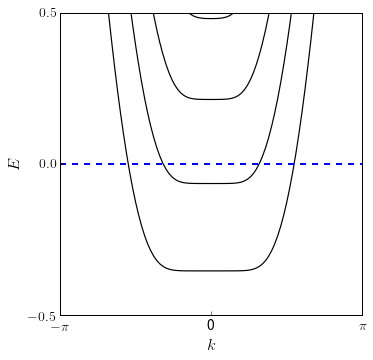

In [2]:
p = SimpleNamespace(t=1, mu=0.5, B=0.15)
sys = qhe_ribbon(W=20)

kwargs = {'k_x': np.linspace(-np.pi, np.pi, 101),
         'xdim': r'$k$',
         'ydim': r'$E$',
         'xticks': pi_ticks,
         'yticks': 3,
         'ylims': [-0.5, 0.5]}
    
spectrum(sys, p, **kwargs) * holoviews.HLine(0)

You can see that, as a consequence of this bending of the Landau levels, even if the Fermi level is placed in the middle of a bulk gap as in the figure, there are states crossing it. We can associate the levels at negative $k$ with states localized at the bottom edge of the ribbon, and those at positive $k$ with states localized at the top edge. For each edge, there are as many edge states as there are filled Landau levels in the bulk of the system.

The particular shape of the dispersion $E(k)$ will depend on the details of the confining potential (which in this case was an infinite square well). However, close to the Fermi level we can always approximate the dispersion $E(k)$ of the edge states as a straight line. We then obtain, for each edge state, a linear relation between energy and momentum,

$$E = \hbar v (k-k_F).$$

Here $k_F$ is the Fermi momentum, which in the case of our ribbon is equal to $k_F = 2\pi N / L$, with $N$ the number of electrons in the system.

Because the slope of the potential is just the local electric field $\mathcal{E}_y=-\partial_y V(y)$ perpendicular to the edge of the sample, the velocity $v$ of the edge states can be simply interpreted as the [drift velocity](http://en.wikipedia.org/wiki/Guiding_center) of a skipping state,

$$v = \mathcal{E}_y/B\,.$$

The velocity is opposite at the two edges because the local electric field $\mathcal{E}$ created by the confining potential always points towards the interior of the sample.

An important thing to note is that the presence of edge states does not depend in any way on the particular shape of the sample as well. You can cut a quantum Hall system in any way you want, but as long as it has edges, it will have edge states. To demonstrate this, let's take a “picture” of the edge states by plotting the local density of states at the Fermi level in a Hall bar.

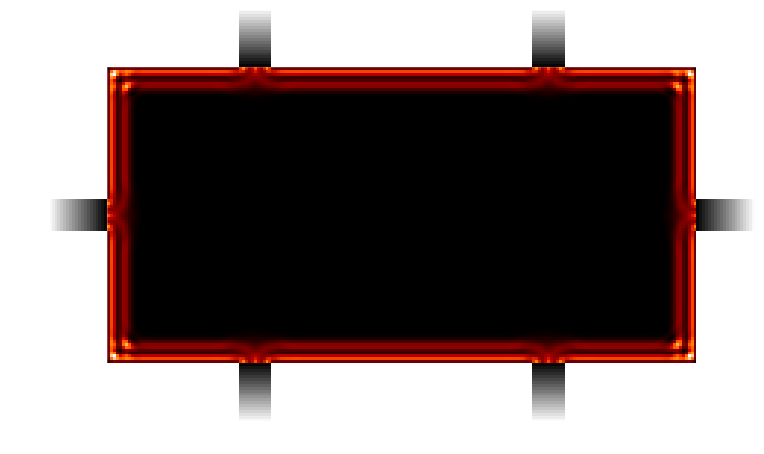

In [3]:
p = SimpleNamespace(t=1, mu = 0.6, mu_lead=0.6, B=0.15, phi=0.0)
sys = qhe_hall_bar(L=200, W=100).finalized()
ldos = kwant.ldos(sys, energy=0.0, args=[p])

fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(1,2,1)
ax.axis('off')
kwant.plotter.map(sys, ldos, num_lead_cells=20, colorbar=False, ax=ax);

The local density of states beautifully reveals the presence of edge states in the sample. You can see that each filled Landau level produces a maximum in the density of states, which goes all around the edges of the sample. In this case, our simulation had two filled Landau levels in the bulk.

In [4]:
question = ("In the plot above, which edge state moves faster, the one closer to the edge or the one further away ?")
answers = ["They go at the same velocity.",
           "The one more towards the bulk, because it is not slowed by the confining potential.",
           "The one closer to the edge, because the local electric field there is stronger.",
           "One cannot tell, because it depends on microscopic details."]
explanation = ("The drift velocity is given by the ratio of the local electric field and the magnetic field. "
               "The slope of the confinement potential increases sharply at the edge, hence the local electric field "
               "is stronger there.")
MoocMultipleChoiceAssessment(question, answers, correct_answer=2, explanation=explanation)

MoocMultipleChoiceAssessment(**{'explanation': 'The drift velocity is given by the ratio of the local electric field and the magnetic field. The slope of the confinement potential increases sharply at the edge, hence the local electric field is stronger there.', 'question': 'In the plot above, which edge state moves faster, the one closer to the edge or the one further away ?', 'answers': ['They go at the same velocity.', 'The one more towards the bulk, because it is not slowed by the confining potential.', 'The one closer to the edge, because the local electric field there is stronger.', 'One cannot tell, because it depends on microscopic details.'], 'correct_answer': 2, 'max_attempts': 2, 'display_name': 'Question'})

# The harmless anomaly of the chiral edges

The chiral edge states can be described in such simple terms, that you might doubt the fact that they cannot exist without a bulk. After all, couldn't we just build a theory of a single chiral edge state, neglecting the bulk of the quantum Hall system and the existence of the other edge? Can't a truly one-dimensional system just show the same behavior of the chiral edge state of the quantum Hall effect?

Let's consider the equation $E=\hbar v (k-k_F)$ which describes these chiral states. We can imagine that a constant electric field $\mathcal{E}$ can be applied along the edge, pallel to the momentum $k$. (In the Hall cylinder, this can be done by threading a time-dependent flux through the cylinder, as you have seen in the previous part of the lecture).

The momentum $k$ changes according to the equation $\hbar \dot{k} = -e\mathcal{E}$. After a time $t$, the energy of a state with momentum $k$ has changed to $\hbar v (k - k_F - e\mathcal{E}t/\hbar)$. This increase corresponds to a time-dependent shift of the Fermi momentum, $k_F\,\to\,k_F + e\mathcal{E}t/\hbar$. Recall that $k_F = 2\pi N/L$ where $N$ is the number of electrons, so the rate of change of $k_F$ gives

$$\dot{N} = \mathcal{E}L/\Phi_0,$$

with $\Phi_0=h/e$ a flux quantum! Since the number of electrons is changing, **charge is not conserved**. In particular, after a time such that $\mathcal{E}L t = \Phi_0$, it seems that exactly one electron has popped out of nowhere at the edge.

At this point, you should understand what's happening. This is just how the Laughlin pump manifests itself if you only look at one edge. The number of electrons at one edge can increase, because electrons are being depleted from the other edge (which is not included in our “theory”) and pumped through the bulk until they appear.

> This property of the edge is referred to as the **chiral anomaly**. The chiral anomaly tells us that we cannot have a consistent theory for a chiral edge state without a bulk, which at the same time conserves electric charge. Chiral edge states, or anything else that exhibits a chiral anomaly, are an example of the bulk edge correspondence, since they can only appear at the edge of a two dimensional system and never in isolation.

We called the anomaly “harmless” since the non-conservation of charge at the edge has a very simple explanation when the rest of the system is included in the picture. If you ever encounter other “anomalous” theories, it might well be a sign that the system under consideration is only the edge of something else!

# Quantization of Hall Conductance from edge states

To conclude our case about chiral edge states, we will now show that both signatures of the quantum Hall effect can be explained solely in terms of the edge states, as long as the interactions between electrons are neglected. In principle, this exercise can be done in any of the sample geometries that you have seen so far: the 6-terminal Hall bar, the Hall cylinder, and the Corbino geometry. We will choose the last one for the sake of convenience.

So let's take again our Corbino disk immersed in an external magnetic field. With respect to last time, we now apply a small voltage difference $V$ between the edges, and there is no flux passing through in the middle of the Corbino disk.

![](figures/corbino_voltage.svg)

In this new drawing, we have also added arrows to indicate that we now know that each edge of the Corbino supports one chiral  state. We cannot resist the temptation of showing you another beautiful plot of the local density of states, showing edge states in the Corbino geometry:

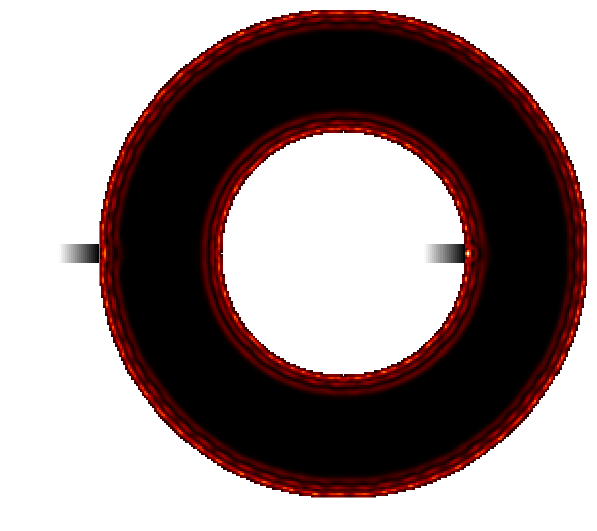

In [5]:
W = 60
p = SimpleNamespace(t=1, mu=0.9, mu_lead=0.9, B=0.15, phi=0.0)
sys = qhe_corbino(2*W, W).finalized()
ldos = kwant.ldos(sys, energy=0.0, args=[p])
fig = plt.figure(figsize=[15, 15])
ax = fig.add_subplot(1,2,1)
ax.axis('off')
kwant.plotter.map(sys, ldos, num_lead_cells=20, colorbar=False, ax=ax)

Note how the local density of states for each edge state oscillates between maxima and minima. This is because the edge state wave functions are standing waves which go all around the Corbino disk.

But back to the point. We want to consider the case when the system is in equilibrium, and we ask what are the currents that flow in the system as a consequence of the small applied voltage $V$.

First, $V$ does not determine the presence of a current *between the edges*. Even though electrons can be injected in the edges, these are separated by the bulk of the system, where due to the position of the Fermi level there are no states available to carry a current. Furthermore, there is no time-dependent flux being threaded through the Corbino disk, so the Laughlin pump is not in motion. Since there is no charge transfer at all in the direction parallel to the applied voltage, we have that the longitudinal conductance $\sigma_L=0$.

However, what is the current $I_\circlearrowleft$ flowing *around* the ring? Because such a current would flow *orthogonally* with respect to the applied voltage, it is associated with the Hall conductance, $I_\circlearrowleft= \sigma_H V$.

Let's first consider the case $V=0$. The Fermi level is then the same at both edges. There are as many electrons going around the ring clockwise on the outer edge, as there are going around counterclockwise on the inner edge. In this case there is no net current flowing around the ring.

A small voltage difference $V$ creates a small imbalance in the electron population between the edges. There will be, say, more electrons running counterclockwise on the inner edge than running clockwise on the outer edge. So we do expect a net current flowing around the ring.

Let's compute the intensity of the current, it's quite simple.

Every chiral edge state is a *transport channel* for the current. Now, the defining property of chiral edge states is that they only allow electrons to travel along the edge in one direction. Electrons have no chance to reverse their velocity, or in other words no chance to *backscatter*.  This means that chiral edge states are perfect transport channels to carry a current, so they have the highest conductance possible. Quantum mechanics limits the maximum conductance that a single transport channel can have to the value $G_0=e^2/h$, which is the conductance quantum you already met last week. With $n$ of these channels, we obtain precisely

$$I_\circlearrowleft = n \,\frac{e^2}{h} V\,.$$


> Thus, the relevant electromagnetic responses, namely the longitudinal and Hall conductivities $\sigma_L=0$ and $\sigma_H=ne^2/h$, can both be derived directly by only considering the chiral edge states.

In [6]:
question = ("At which energy did we set the Fermi level in the density of states plot for the Corbino disk?")
answers = ["It is impossible to answer on the base of the plot alone, because it depends on the voltages applied to the leads.",
           "Exactly at the same energy as the third Landau level.",
           "Between the second and the third Landau levels.",
           "Between the third and the fourth Landau levels."]
explanation = ("There are three edge states visible in the figure. "
               "Hence there are three filled Landau levels in the bulk, " 
               "so the Fermi level lies somewhere above the third, but below the fourth Landau level.")
MoocMultipleChoiceAssessment(question, answers, correct_answer=3, explanation=explanation)

MoocMultipleChoiceAssessment(**{'explanation': 'There are three edge states visible in the figure. Hence there are three filled Landau levels in the bulk, so the Fermi level lies somewhere above the third, but below the fourth Landau level.', 'question': 'At which energy did we set the Fermi level in the density of states plot for the Corbino disk?', 'answers': ['It is impossible to answer on the base of the plot alone, because it depends on the voltages applied to the leads.', 'Exactly at the same energy as the third Landau level.', 'Between the second and the third Landau levels.', 'Between the third and the fourth Landau levels.'], 'correct_answer': 3, 'max_attempts': 2, 'display_name': 'Question'})

# Important things to know about edge states

The physical picture that we presented this week is very simple, and it is also somewhat simplified.

In the summary video of this week, Bert Halperin from Harvard University will discuss how disorder and interactions enter in the description of the quantum Hall effect, and where the electric current is really carried. In 1982, Bert was the [first to understand](http://sites.fas.harvard.edu/~phys191r/References/e3/halperin1982.pdf) that the quantum Hall effect could be explained by the existence of chiral edge states, so we are very happy that you can learn the story directly from him.

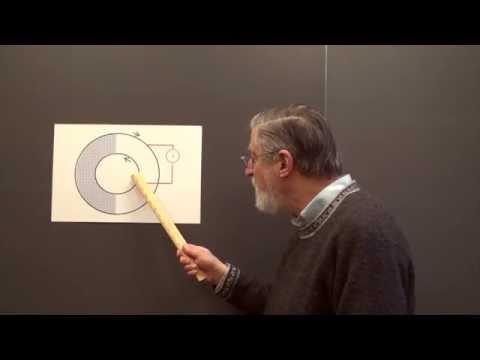

In [7]:
MoocVideo("rQs12c-SieE", src_location='3.3-summary')

**Questions about what you just learned? Ask them below!**

In [8]:
MoocDiscussion("Questions", "Chiral edge states")

MoocDiscussion(**{'discussion_id': '2183a03779e43a20f9a63b44c3ea24e7', 'discussion_category': 'Questions', 'discussion_target': 'Chiral edge states', 'display_name': 'Chiral edge states'})